# Sandbox

Sandbox script to work on functions while other functions are running in the background

In [583]:
%reset -f

In [584]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [585]:
%reload_ext autoreload
%autoreload 2

In [586]:
# analysis functions
import xarray as xr
import numpy as np
import pandas as pd

# plotting functions
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

# systems functions
import os
from collections import defaultdict

# my own classes and functions
from GradTrendClasses import ModelInput, Trend, TrendPlotting, CalculateMMEGradient, CalculateObsGradient
from GradientProjectFunctions import CropTrendsDf, RemoveClimatology, DictToDf, TrendsDictFromFiles, CalculateTrendPercentile, FlagInRange, ClassifyModels, CreateScenarioDictionary, ClassifyHistModelsLite

## Script that calculates the jump and combines it with information about whether this was random or non-random

### Assignment information for all models that were run together

In [595]:
matchDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Model_Statistics_NonParent'
os.chdir(matchDir)

fileName = 'Match_data_NonParent.csv'
matchData = pd.read_csv(fileName, index_col = 0)

# creating a new column with the model name (note that these are all before the first _)
models = []
for modelName in list(matchData.index):
    charIndex = modelName.index('_')
    models.append(modelName[:charIndex])
    
matchData['Model'] = models
matchData.reindex(columns = ['Model', 'ScenModel', 'Assignment']);

In [596]:
matchData.Model.unique()

array(['CanESM5', 'CNRM-CM6-1', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR',
       'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-LR', 'GISS-E2-1-G'],
      dtype=object)

In [589]:
# from the concat jump function

# want to add in a function to also have it be compared to Dec / Jan jumps for the rest of the period
gradientsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Gradients_2024-03-16'
os.chdir(gradientsDir)

# list of models that we are interested in for this
#models = ['CanESM5', 'IPSL-CM6A-LR', 'MIROC6', 'GISS-E2-1-G']
models = ['CNRM-CM6-1', 'ACCESS-ESM1-5', 'MIROC-ES2L']

# list for holding model names
modelNamesGrad = []

# lists for holding the concat information
concatJumpFullHist = []
concatJumpJanDec = []

for modelName in models:
    
    # get a list of all of the files in the directory (getting rid of the python checkpoints one)
    gradientFiles = os.listdir(gradientsDir)
    gradientFiles = [f for f in gradientFiles if '.nc' in f and modelName in f]

    histStart = '1850-01-16T12:00:00.000000000'
    histEnd = '2014-12-16T12:00:00.000000000'
    scenStart = '2015-01-16T12:00:00.000000000'

    for file in gradientFiles:      
        # getting the modelName
        charIndex = file.index('.')
        modelNamesGrad.append(file[:charIndex])

        # calculating the jump relative to std
        modelGradient = xr.open_dataset(file)
        jump = (modelGradient.sel(time = histEnd) - modelGradient.sel(time = scenStart)).ts.item()

        # calculating standard deviation of historical period
        stdHist = modelGradient.sel(time = slice(histStart, histEnd)).std(dim = 'time').ts.item()
        meanHist = modelGradient.sel(time = slice(histStart, histEnd)).mean(dim = 'time').ts.item()

        concatJumpFullHist.append((jump - meanHist)/stdHist)

        # calculating difference between December and January for historical period
        # first selecting the right period so that we have Jan of 1851 and December of 1850 at the start and Jan 2015 and Dec 2014 at the end
        janStart = '1851-01-16T12:00:00.000000000'
        janEnd = '2015-02-16T12:00:00.000000000'
        decStart = '1850-01-16T12:00:00.000000000'
        decEnd = '2015-01-16T12:00:00.000000000'

        janValues = modelGradient.sel(time = slice(janStart, janEnd)).where(modelGradient['month'] == 1, drop = True).ts.values
        decValues = modelGradient.sel(time = slice(decStart, decEnd)).where(modelGradient['month'] == 12, drop = True).ts.values
        janDecDiff = janValues - decValues
        janDecDiffMean = np.mean(janDecDiff)
        janDecDiffSTD = np.std(janDecDiff)

        concatJumpJanDec.append((jump - janDecDiffMean)/janDecDiffSTD)
        
# adding in the jump information for all of the models
# first get a list of jump information corresponding to the histModel indices
jumpMatchHist = np.zeros(len(matchData.index))
jumpMatchJanDec = np.zeros(len(matchData.index))

for i, histModelMatch in enumerate(matchData.index):
    if histModelMatch in modelNamesGrad:
        jumpMatchHist[i] = concatJumpFullHist[modelNamesGrad.index(histModelMatch)]
        jumpMatchJanDec[i] = concatJumpJanDec[modelNamesGrad.index(histModelMatch)]
    else:
        jumpMatchHist[i] = np.nan
        jumpMatchJanDec[i] = np.nan

# now append this to the matchData frame
matchData['ConcatJumpHist'] = jumpMatchHist
matchData['ConcatJumpJanDec'] = jumpMatchJanDec

# adding in a column of colours based on assigment
colours = []

for assignment in matchData.Assignment:
    if assignment == 'Random':
        colours.append('Red')
    else:
        colours.append('Blue')

matchData['Colour_Assignment'] = colours

FileNotFoundError: [Errno 2] No such file or directory: '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Gradients_2024-03-16'

In [590]:
matchData.head()

,ScenModel,Assignment,Model
HistModel,,,
CanESM5_r10i1p1f1,CanESM5_r10i1p1f1,Non-random,CanESM5
CanESM5_r10i1p2f1,CanESM5_r10i1p2f1,Non-random,CanESM5
CanESM5_r11i1p1f1,CanESM5_r11i1p1f1,Non-random,CanESM5
CanESM5_r11i1p2f1,CanESM5_r11i1p2f1,Non-random,CanESM5
CanESM5_r12i1p1f1,CanESM5_r12i1p1f1,Non-random,CanESM5


## Plotting

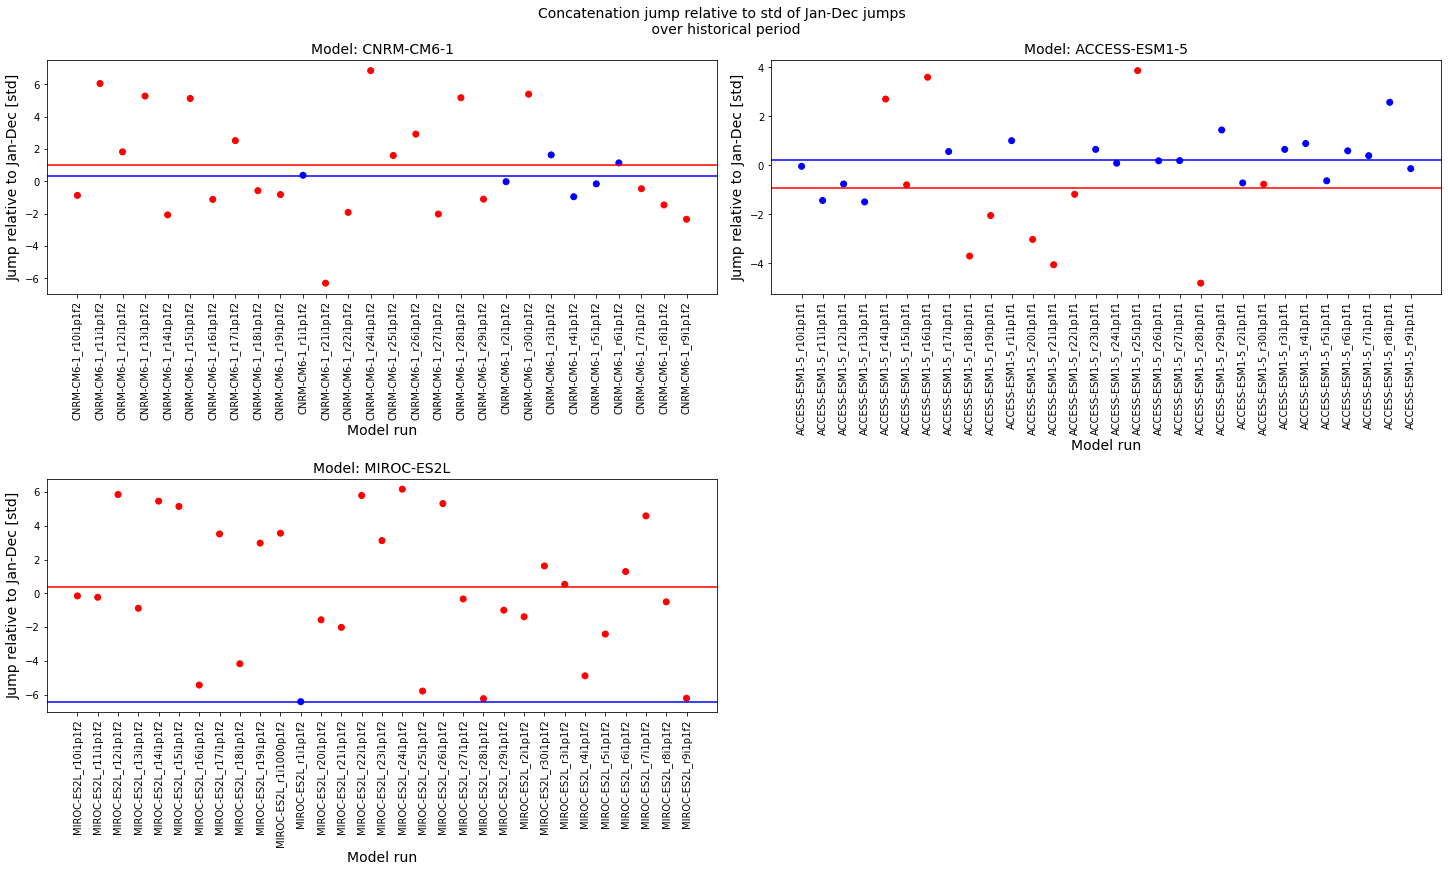

In [580]:
# for loop for all four models
nFigures = len(models)
nCols = 2

if nFigures % nCols == 0:
    nRows = int(nFigures/nCols)
else:
    nRows = int(np.floor(nFigures/nCols) + 1)

subplotSize = (10, 6)
figWidth = nCols * subplotSize[0]
figHeight = nRows * subplotSize[1]
fig = plt.figure(figsize = (figWidth, figHeight), constrained_layout = True)
fig.suptitle('Concatenation jump relative to std of Jan-Dec jumps \n over historical period', fontsize = 14)

for i, model in enumerate(models):
    # creating the axes
    ax = fig.add_subplot(nRows, nCols, i+1)
    
    # filtering the dataframe for the model
    dfOneModel = matchData[matchData.Model == model]
    
    # calculating the mean by assignment
    try:
        meanNonRandom = dfOneModel.groupby('Assignment').ConcatJumpJanDec.mean()['Non-random']
    except Exception:
        meanNonRandom = np.nan
    
    try:
        meanRandom = dfOneModel.groupby('Assignment').ConcatJumpJanDec.mean()['Random']
    except Exception:
        meanRandom = np.nan

    # plotting the scatter plot from the dataframe
    ax.scatter(dfOneModel.index, dfOneModel.ConcatJumpJanDec, c = dfOneModel.Colour_Assignment)
    ax.set_title(f'Model: {model}', fontsize = 14)
    ax.set_xlabel('Model run', fontsize = 14)
    ax.set_ylabel('Jump relative to Jan-Dec [std]', fontsize = 14)
    ax.set_xticks(range(len(dfOneModel.index)))
    ax.set_xticklabels(dfOneModel.index, rotation = 90)
    ax.axhline(y = meanNonRandom, color = 'Blue')
    ax.axhline(y = meanRandom, color = 'Red')

plt.show()

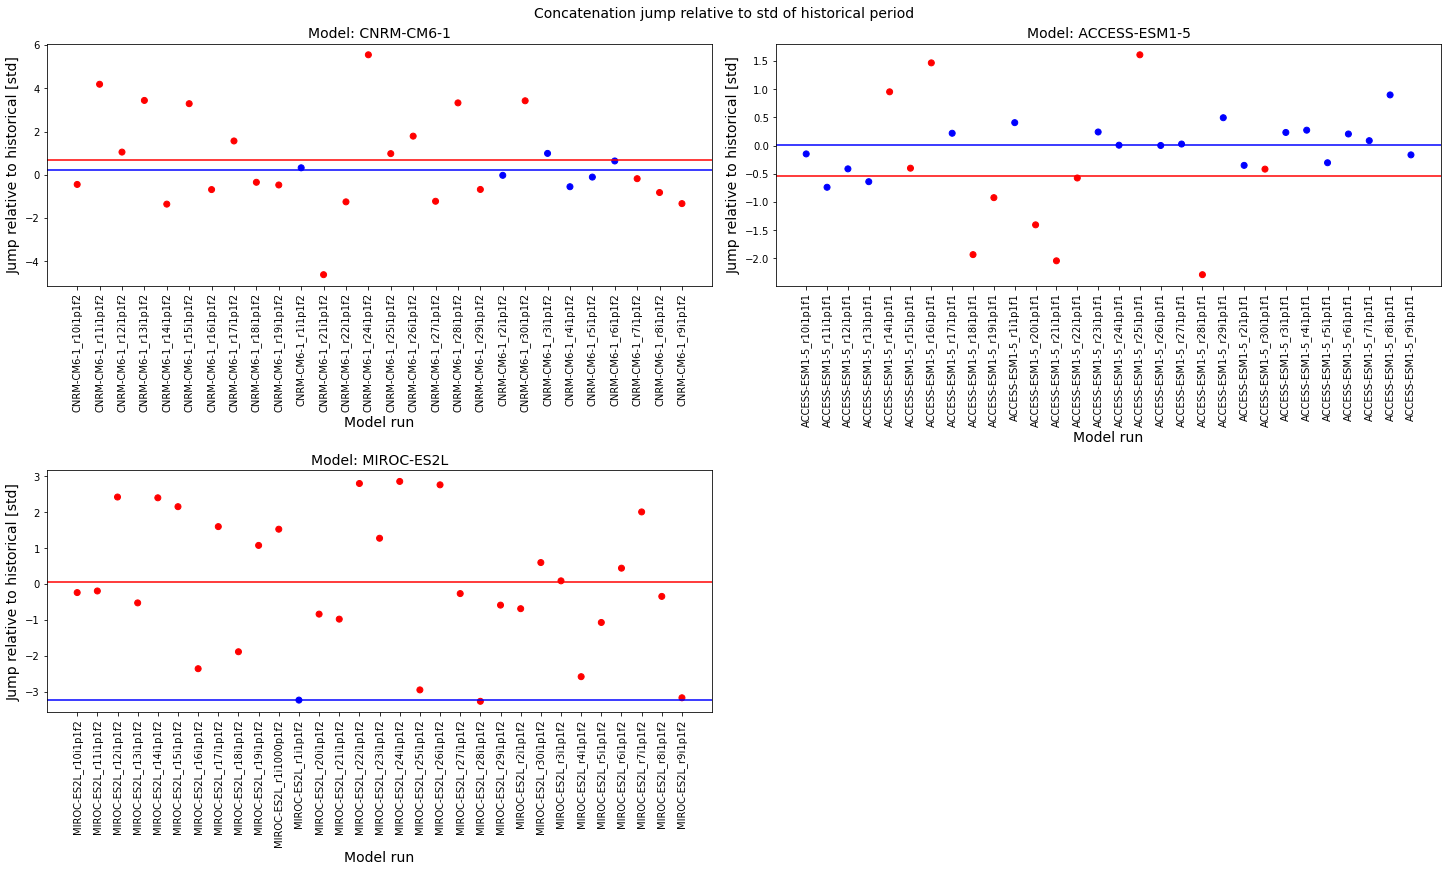

In [581]:
# for loop for all four models
nFigures = len(models)
nCols = 2

if nFigures % nCols == 0:
    nRows = int(nFigures/nCols)
else:
    nRows = int(np.floor(nFigures/nCols) + 1)

subplotSize = (10, 6)
figWidth = nCols * subplotSize[0]
figHeight = nRows * subplotSize[1]
fig = plt.figure(figsize = (figWidth, figHeight), constrained_layout = True)
fig.suptitle('Concatenation jump relative to std of historical period', fontsize = 14)

for i, model in enumerate(models):
    # creating the axes
    ax = fig.add_subplot(nRows, nCols, i+1)
    
    # filtering the dataframe for the model
    dfOneModel = matchData[matchData.Model == model]
    
    # calculating the mean by assignment
    try:
        meanNonRandom = dfOneModel.groupby('Assignment').ConcatJumpHist.mean()['Non-random']
    except Exception:
        meanNonRandom = np.nan
    
    try:
        meanRandom = dfOneModel.groupby('Assignment').ConcatJumpHist.mean()['Random']
    except Exception:
        meanRandom = np.nan

    # plotting the scatter plot from the dataframe
    ax.scatter(dfOneModel.index, dfOneModel.ConcatJumpHist, c = dfOneModel.Colour_Assignment)
    ax.set_title(f'Model: {model}', fontsize = 14)
    ax.set_xlabel('Model run', fontsize = 14)
    ax.set_ylabel('Jump relative to historical [std]', fontsize = 14)
    ax.set_xticks(range(len(dfOneModel.index)))
    ax.set_xticklabels(dfOneModel.index, rotation = 90)
    ax.axhline(y = meanNonRandom, color = 'Blue')
    ax.axhline(y = meanRandom, color = 'Red')

plt.show()

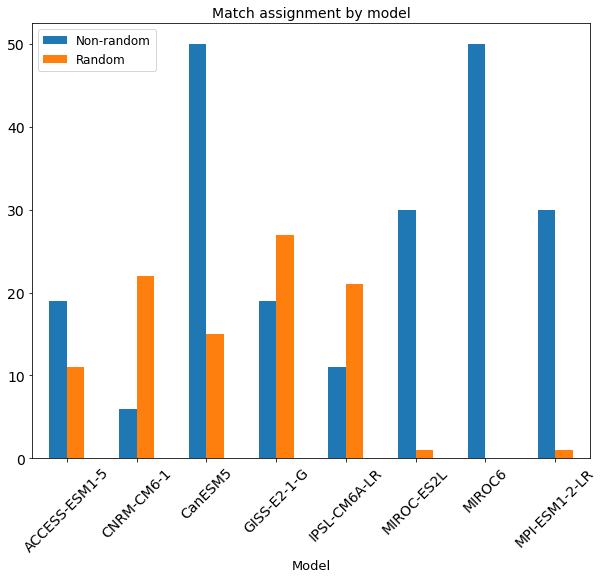

In [597]:
fig, ax = plt.subplots(figsize = (10,8))
dfGrouped = matchData.groupby(['Model', 'Assignment']).size().reset_index(name = 'Counts')
plot = dfGrouped.pivot_table(index = 'Model', columns = 'Assignment', fill_value = 0).plot(kind = 'bar', ax = ax, fontsize = 14)
plot.set_title('Match assignment by model', fontsize = 14)
plot.legend(['Non-random', 'Random'], fontsize = 12)
plot.set_xlabel('Model', fontsize = 13)
plot.set_xticklabels(ax.get_xticklabels(minor = False), rotation = 45)
plt.show()

In [594]:
matchData[matchData.Model == 'MIROC-ES2L']

,ScenModel,Assignment,Model
HistModel,,,
MIROC-ES2L_r10i1p1f2,MIROC-ES2L_r1i1p1f2,Random,MIROC-ES2L
MIROC-ES2L_r11i1p1f2,MIROC-ES2L_r2i1p1f2,Random,MIROC-ES2L
MIROC-ES2L_r12i1p1f2,MIROC-ES2L_r3i1p1f2,Random,MIROC-ES2L
MIROC-ES2L_r13i1p1f2,MIROC-ES2L_r2i1p1f2,Random,MIROC-ES2L
MIROC-ES2L_r14i1p1f2,MIROC-ES2L_r24i1p1f2,Random,MIROC-ES2L
MIROC-ES2L_r15i1p1f2,MIROC-ES2L_r19i1p1f2,Random,MIROC-ES2L
MIROC-ES2L_r16i1p1f2,MIROC-ES2L_r27i1p1f2,Random,MIROC-ES2L
MIROC-ES2L_r17i1p1f2,MIROC-ES2L_r18i1p1f2,Random,MIROC-ES2L
MIROC-ES2L_r18i1p1f2,MIROC-ES2L_r18i1p1f2,Random,MIROC-ES2L
